# 论文题目：Variational Quantum Singular Value Deposition(VQSVD)

## 项目介绍

### SVD

**奇异值分解**(Singular Value Decomposition，简称**SVD**)是线性代数中一种重要的矩阵分解，它作为特征分解在任意维数矩阵上的推广，在机器学习领域中被广泛应用，常用于矩阵压缩、推荐系统以及自然语言处理等。

**定义**：给定一个复数矩阵 $M \in \mathbb{C}^{m \times n}$ ，则定义矩阵 $M$ 的**SVD**为： $M = UDV^\dagger$ 。其中 $U$ 是 $m \times m$ 的矩阵， $V$ 是 $n \times n$ 的矩阵， $U, V$ 都是酉矩阵，即满足 $UU^\dagger = I, VV^\dagger = I$ 。$D$ 是 $m \times n$ 的对角阵，主对角线上的的元素从大到小排列，每个元素都称为矩阵 $M$ 的奇异值。

### VQSVD

**变分量子奇异值分解**(Variational Quantum Singular Value Decomposition，简称**VQSVD**)将SVD转换成优化问题，并通过变分量子线路求解。

论文将矩阵奇异值分解分成4个步骤求解：

1. 输入待分解的矩阵 $M$ ，想压缩到的阶数 $T$ ，权重 $Weights$ ，测量基 $\{ | \psi_1\rangle,\cdots |\psi_T\rangle\}$ ，参数化的酉矩阵 $U(\theta)$ 和 $V(\phi)$ （即ansatz）；
2. 搭建量子神经网络估算奇异值 $m_j = \text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$ ，并最大化加权奇异值的和 $L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$ ，其中，加权是为了让计算出的奇异值从大到小排列；
3. 读出最大化时参数值 $\alpha^ \star$ 和 $\beta^\star$ ，计算出 $U(\alpha^\star)$ 和 $V(\beta^\star)$
4. 输出结果：奇异值 ${m_1, \cdots, m_r}$ 和奇异矩阵 $U(\alpha^\star)$ 和 $V(\beta^\star)$

![VQSVD steps](https://gitee.com/mindspore/mindquantum/raw/research/paper_recurrence/38_lolo1222/figure/QSVD.png)

## 复现过程

### 案例1：分解随机生成的8*8复数矩阵

在导入MindQuantum之前设置模拟器使用的并行线程数。

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

需要使用的包：

In [2]:
import mindspore as ms
from mindquantum import Simulator, MQAnsatzOnlyLayer, add_prefix
from mindquantum import Hamiltonian, Circuit, RY, RZ, X

import numpy as np
from scipy.sparse import csr_matrix
from scipy.linalg import norm
from matplotlib import pyplot
import tqdm

定义常数并设置权重：

In [3]:
n_qubits = 3  # qbits number
cir_depth = 20  # circuit depth
N = 2**n_qubits
rank = 8  # learning rank
step = 3
ITR = 200  # iterations
LR = 0.02  # learning rate

# Set equal learning weights
if step == 0:
    weight = ms.Tensor(np.ones(rank))
else:
    weight = ms.Tensor(np.arange(rank * step, 0, -step))

随机生成一个8*8的复数矩阵M

In [4]:
# Define random seed
np.random.seed(42)


def mat_generator():
    '''
    Generate a random complex matrix
    '''
    matrix = np.random.randint(
        10, size=(N, N)) + 1j * np.random.randint(10, size=(N, N))
    return matrix


# Generate matrix M which will be decomposed
M = mat_generator()

# m_copy is generated to error analysis
m_copy = np.copy(M)

# Print M
print('Random matrix M is: ')
print(M)

# Get SVD results
U, D, v_dagger = np.linalg.svd(M, full_matrices=True)

Random matrix M is: 
[[6.+1.j 3.+9.j 7.+3.j 4.+7.j 6.+6.j 9.+8.j 2.+7.j 6.+4.j]
 [7.+1.j 4.+4.j 3.+7.j 7.+9.j 7.+8.j 2.+8.j 5.+0.j 4.+8.j]
 [1.+6.j 7.+8.j 5.+7.j 1.+0.j 4.+7.j 0.+7.j 9.+2.j 5.+0.j]
 [8.+7.j 0.+2.j 9.+2.j 2.+0.j 6.+4.j 3.+9.j 8.+6.j 2.+9.j]
 [4.+8.j 2.+6.j 6.+8.j 4.+7.j 8.+1.j 6.+0.j 1.+6.j 3.+6.j]
 [8.+7.j 1.+4.j 9.+2.j 8.+7.j 9.+5.j 4.+2.j 1.+0.j 3.+2.j]
 [6.+4.j 7.+2.j 2.+0.j 0.+4.j 3.+9.j 1.+6.j 7.+6.j 3.+8.j]
 [1.+9.j 5.+9.j 5.+2.j 9.+6.j 3.+0.j 5.+3.j 1.+3.j 9.+4.j]]


定义论文中使用的ansatz类：

In [5]:
class Ansatz:
    '''
    Define ansatz
    '''

    def __init__(self, n, depth):
        self.circ = Circuit()
        num = 0
        for _ in range(depth):

            for i in range(n):
                self.circ += RY('theta' + str(num)).on(i)
                num += 1

            for i in range(n):
                self.circ += RZ('theta' + str(num)).on(i)
                num += 1

            for i in range(n - 1):
                self.circ += X.on(i + 1, i)

            self.circ += X.on(0, n - 1)

定义画出优化过程中的学习曲线的函数：

In [6]:
def loss_plot(loss):
    '''
    Plot loss over iteration
    '''
    pyplot.plot(list(range(1, len(loss) + 1)), loss)
    pyplot.xlabel('iteration')
    pyplot.ylabel('loss')
    pyplot.title('Loss Over Iteration')
    pyplot.suptitle('step = ' + str(step))
    pyplot.show()

定义不同测量基下的量子网络。

`get_expectation_with_grad` 方法可以用来计算如下表达式的值和线路中参数的梯度。

$$
E(\theta) = \langle\phi|U_l^{\dagger}(\theta) H U_r(\theta)|\psi\rangle
$$

将待分解矩阵M嵌入哈密顿量H中，将 $U_l(\theta)$ 设置成 $U(\theta)$ ， $U_r(\theta)$ 设置成 $V(\phi)$ ，通过模拟器的`set_qs`设置模拟器的状态为给定的测量基，从而获取到该测量基下的测量结果，即对应位置的奇异值。再使用 `MQAnsatzOnlyLayer` 即搭建出基于给定测量基下的量子网络层，其输出为 $\text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$ 。

In [7]:
def quantnet(qubits_num, hams, circ_right, circ_left=None, base=None):
    '''
    Generate quantum net using hams, circ_right and circ_left under given base
    '''
    sim = Simulator('projectq', qubits_num)

    if base is None:
        pass
    else:
        sim.set_qs(base)
    grad_ops = sim.get_expectation_with_grad(hams, circ_right, circ_left)

    ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

    quantumnet = MQAnsatzOnlyLayer(grad_ops, 'ones')

    return quantumnet

实例化要使用到的ansatz：U_ansatz和V_ansatz

In [9]:
# Define ansatz

u_ansatz = add_prefix(Ansatz(n_qubits, cir_depth).circ, 'u')
v_ansatz = add_prefix(Ansatz(n_qubits, cir_depth).circ, 'v')
v_ansatz

q0: ──RY(v_theta0)────RZ(v_theta3)────●─────────X────RY(v_theta6)─────RZ(v_theta9)────●─────────X────RY(v_theta12)────RZ(v_theta15)────●─────────X────RY(v_theta18)────RZ(v_theta21)────●─────────X────RY(v_theta24)────RZ(v_theta27)────●─────────X────RY(v_theta30)────RZ(v_theta33)────●─────────X────RY(v_theta36)────RZ(v_theta39)────●─────────X────RY(v_theta42)────RZ(v_theta45)────●─────────X────RY(v_theta48)────RZ(v_theta51)────●─────────X────RY(v_theta54)────RZ(v_theta57)────●─────────X────RY(v_theta60)────RZ(v_theta63)────●─────────X────RY(v_theta66)────RZ(v_theta69)────●─────────X────RY(v_theta72)────RZ(v_theta75)────●─────────X────RY(v_theta78)────RZ(v_theta81)────●─────────X────RY(v_theta84)────RZ(v_theta87)────●─────────X────RY(v_theta90)────RZ(v_theta93)────●─────────X────RY(v_theta96)────RZ(v_theta99)─────●─────────X────RY(v_theta102)────RZ(v_theta105)────●─────────X────RY(v_theta108)────RZ(v_theta111)────●─────────X────RY(v_theta114)────RZ(v_theta117)────●─────────X──
                                      │         │                                     │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                      │         │                                       │         │                                        │         │                                        │         │                                        │         │
q1: ──RY(v_theta1)────RZ(v_theta4)────X────●────┼────RY(v_theta7)────RZ(v_theta10)────X────●────┼────RY(v_theta13)────RZ(v_theta16)────X────●────┼────RY(v_theta19)────RZ(v_theta22)────X────●────┼────RY(v_theta25)────RZ(v_theta28)────X────●────┼────RY(v_theta31)────RZ(v_theta34)────X────●────┼────RY(v_theta37)────RZ(v_theta40)────X────●────┼────RY(v_theta43)────RZ(v_theta46)────X────●────┼────RY(v_theta49)────RZ(v_theta52)────X────●────┼────RY(v_theta55)────RZ(v_theta58)────X────●────┼────RY(v_theta61)────RZ(v_theta64)────X────●────┼────RY(v_theta67)────RZ(v_theta70)────X────●────┼────RY(v_theta73)────RZ(v_theta76)────X────●────┼────RY(v_theta79)────RZ(v_theta82)────X────●────┼────RY(v_theta85)────RZ(v_theta88)────X────●────┼────RY(v_theta91)────RZ(v_theta94)────X────●────┼────RY(v_theta97)────RZ(v_theta100)────X────●────┼────RY(v_theta103)────RZ(v_theta106)────X────●────┼────RY(v_theta109)────RZ(v_theta112)────X────●────┼────RY(v_theta115)────RZ(v_theta118)────X────●────┼──
                                           │    │                                          │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                           │    │                                            │    │                                             │    │                                             │    │                                             │    │
q2: ──RY(v_theta2)────RZ(v_theta5)─────────X────

实例化量子网络层，将待分解的8*8矩阵M稀疏化后生成相应的哈密顿量H，使用计算基$\{ |000\rangle, |001\rangle,\cdots |111\rangle\}$利用量子神经网络计算奇异值 $m_j = \text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$ 。

In [8]:
# Embed M matrix into Hamiltonian ham

ham = Hamiltonian(csr_matrix(M))

i_matrix = np.identity(N)
quantum_models = dict()
quantum_models['net_0'] = quantnet(n_qubits, ham, v_ansatz, u_ansatz,
                                   i_matrix[0])
for s in range(1, rank):
    quantum_models["net_" + str(s)] = quantnet(n_qubits, ham, v_ansatz,
                                               u_ansatz, i_matrix[s])
    quantum_models["net_" + str(s)].weight = quantum_models['net_0'].weight


结合**MindSpore**提供的经典学习框架构建出量子经典混合网络，实现对量子网络层加权求和，计算出 $L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$ 。

In [9]:
class MyNet(ms.nn.Cell):
    '''
    define quantum-classic net
    '''

    def __init__(self):
        super(MyNet, self).__init__()

        self.build_block = ms.nn.CellList()
        for j in range(rank):
            self.build_block.append(quantum_models["net_" + str(j)])

    def construct(self):
        x = self.build_block[0]() * weight[0]
        k = 1

        for layer in self.build_block[1:]:
            x += layer() * weight[k]
            k += 1

        return -x

实例化量子经典混合网络并调用**MindSpore**的API开始训练：

In [10]:
# Define network
net = MyNet()

# Define optimizer
opt = ms.nn.Adam(net.trainable_params(), learning_rate=LR)

# Simple gradient descent
train_net = ms.nn.TrainOneStepCell(net, opt)

# Start to train net
loss_list = list()
for itr in tqdm.tqdm(range(ITR)):
    res = train_net()
    loss_list.append(res.asnumpy().tolist())

100%|██████████| 200/200 [03:57<00:00,  1.19s/it]


读取训练出的结果，即奇异值：

In [11]:
singular_value = list()

for _, qnet in quantum_models.items():
    singular_value.append(qnet().asnumpy()[0])

观察学习曲线以判断是否收敛：

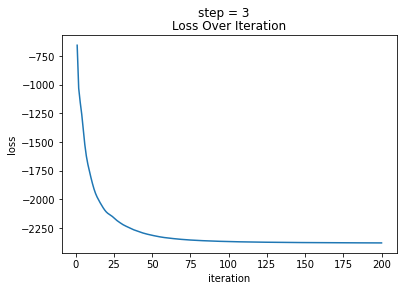

In [12]:
loss_plot(loss_list)

通过学习曲线我们可以发现损失函数已收敛。

接下来打印出学习到的奇异值结果，并与经典比较：

In [13]:
print('Predicted singular values from large to small:', singular_value)
print("True singular values from large to small:", D)

Predicted singular values from large to small: [54.83174, 19.169168, 14.88653, 11.093878, 10.533753, 7.648352, 5.5560594, -0.3320913]
True singular values from large to small: [54.83484985 19.18141073 14.98866247 11.61419557 10.15927045  7.60223249
  5.81040539  3.30116001]


直观上我们可以看到使用量子经典混合网络学习出的奇异值与真实奇异值相差不大。

接下来我们数值分析使用VQSVD进行矩阵压缩的误差。

我们使用前 $T$ 个奇异值和前 $T$ 个左右奇异向量组合出新的矩阵 $M_{re}^{(T)}$ 来近似表示矩阵 $M$ :

$$
M_{re}^{(T)} = U^{(T)}D^{(T)}({V^{(T)}})^{ \dagger}
$$

这样近似的误差为: $error = ||M - M_{re}^{(T)}||$ 。

设矩阵 $M$ 的秩为 $r$ ，即奇异值个数为 $r$ ，则误差随着使用奇异值的数量变多会越来越小。经典的奇异值算法可以保证 $\lim_{T\rightarrow r} ||M - M_{re}^{(T)}||^2_F = 0$ 。


其中矩阵间的距离我们使用 Frobenius-norm 来度量: 

$${||M|{|_F}} = $$

$$\sqrt{\sum_{i,j} \left|M_{ij}\right|^2}$$

为了测量误差，我们首先取出网络中的参数值并赋给U_ansatz和V_ansatz，以获得学习出的奇异矩阵：

In [14]:
# Get parameters value
value = quantum_models['net_0'].weight.asnumpy()
v_value = value[:120]
u_value = value[120:]

# Calculate U and V
u_learned = u_ansatz.matrix(u_value)
v_learned = v_ansatz.matrix(v_value)

v_dagger_learned = np.conj(v_learned.T)
d_learned = np.array(singular_value)

我们将学习到的奇异值分解结果组装回去，与原矩阵计算 Frobenius-norm 误差以观察效果，并与经典奇异值分解的误差作比较：

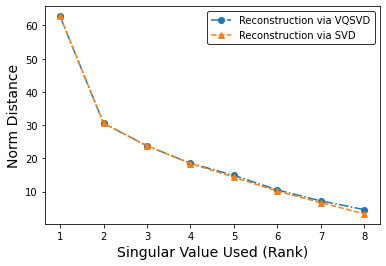

In [15]:
err_subfull, err_local, err_svd = [], [], []
U, D, v_dagger = np.linalg.svd(M, full_matrices=True)

# Calculate Frobenius-norm error
for t in range(rank):
    lowrank_mat = np.matrix(U[:, :t]) * np.diag(D[:t]) * np.matrix(
        v_dagger[:t, :])
    recons_mat = np.matrix(u_learned[:, :t]) * np.diag(
        d_learned[:t]) * np.matrix(v_dagger_learned[:t, :])
    err_local.append(norm(lowrank_mat - recons_mat))
    err_subfull.append(norm(m_copy - recons_mat))
    err_svd.append(norm(m_copy - lowrank_mat))

# Plot SVD error and VQSVD error
fig, ax = pyplot.subplots()
ax.plot(list(range(1, rank + 1)),
        err_subfull,
        "o-.",
        label='Reconstruction via VQSVD')
ax.plot(list(range(1, rank + 1)),
        err_svd,
        "^--",
        label='Reconstruction via SVD')
# ax.plot(list(range(1, rank + 1)), err_local, "*--", label='SVD V/S QSVD')
pyplot.xlabel('Singular Value Used (Rank)', fontsize=14)
pyplot.ylabel('Norm Distance', fontsize=14)
leg = pyplot.legend(frameon=True)
leg.get_frame().set_edgecolor('k')

可以看到，使用量子神经网络分解出的奇异值结果误差与经典奇异值分解的误差十分接近。

---
## 案例2：图像压缩

我们先引入图像处理的包，并导入提前准备好的图片。

In [16]:
from PIL import Image

# Open figure MNIST_32.jpg and get matrix form
img = Image.open(r'.\\figure\\MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat) / 255

### 使用经典SVD压缩图像的效果

我们分别取前5、10、15个奇异值作图像压缩，观察结果。

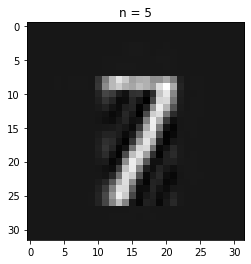

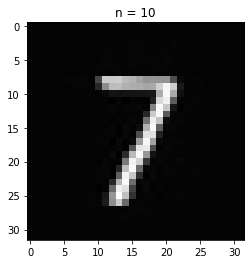

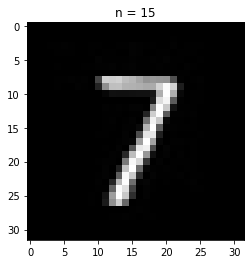

In [17]:
# Get SVD results and show it
U, sigma, V = np.linalg.svd(imgmat)

for t in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :t]) * np.diag(sigma[:t]) * np.matrix(V[:t, :])
    pyplot.imshow(reconstimg, cmap='gray')
    title = "n = %s" % t
    pyplot.title(title)
    pyplot.show()

### 量子版本的分解效果：

此处我们展示取前8个奇异值作图像压缩的过程及最终结果。

In [18]:
# Set super parameters
n_qubits = 5  # qbits number
cir_depth = 40  # circuit depth
N = 2**n_qubits
rank = 8  # learning rank
step = 2
ITR = 200  # iterations
LR = 0.02  # learning rate
SEED = 14  # random seed

# Set equal learning weights
if step == 0:
    weight = ms.Tensor(np.ones(rank))
else:
    weight = ms.Tensor(np.arange(rank * step, 0, -step))


def mat_generator(image):
    '''
    Generate matrix by input image
    '''
    img_matrix = np.array(list(image.getdata(band=0)), float)
    img_matrix.shape = (image.size[1], image.size[0])
    img_np = np.matrix(img_matrix)
    return img_np


# Generate matrix M which will be decomposed
M = mat_generator(img)

# Get SVD results
U, D, v_dagger = np.linalg.svd(M, full_matrices=True)

定义论文中使用的ansatz类：

In [19]:
class Ansatz:
    '''
    Define ansatz
    '''

    def __init__(self, n, depth):
        self.circ = Circuit()
        num = 0
        for _ in range(depth):

            for i in range(n):
                self.circ += RY('theta' + str(num)).on(i)
                num += 1

            for i in range(n - 1):
                self.circ += X.on(i + 1, i)

In [20]:
def quantnet(qubits_num, hams, circ_right, circ_left=None, base=None):
    '''
    Generate quantum net using hams, circ_right and circ_left under given base
    '''
    sim = Simulator('projectq', qubits_num)

    if base is None:
        pass
    else:
        sim.set_qs(base)
    grad_ops = sim.get_expectation_with_grad(hams, circ_right, circ_left)

    ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

    quantumnet = MQAnsatzOnlyLayer(grad_ops, 'ones')

    return quantumnet

In [21]:
# Define ansatz
u_ansatz = add_prefix(Ansatz(n_qubits, cir_depth).circ, 'u')
v_ansatz = add_prefix(Ansatz(n_qubits, cir_depth).circ, 'v')

In [22]:
# Embed M matrix into Hamiltonian ham
ham = Hamiltonian(csr_matrix(M))

i_matrix = np.identity(N)
quantum_models = dict()
quantum_models['net_0'] = quantnet(n_qubits, ham, v_ansatz, u_ansatz,
                                   i_matrix[0])
for s in range(1, rank):
    quantum_models["net_" + str(s)] = quantnet(n_qubits, ham, v_ansatz,
                                               u_ansatz, i_matrix[s])
    quantum_models["net_" + str(s)].weight = quantum_models['net_0'].weight

In [23]:
class MyNet(ms.nn.Cell):
    '''
    define quantum-classic net
    '''

    def __init__(self):
        super(MyNet, self).__init__()

        self.build_block = ms.nn.CellList()
        for j in range(rank):
            self.build_block.append(quantum_models["net_" + str(j)])

    def construct(self):
        x = self.build_block[0]() * weight[0]
        k = 1

        for layer in self.build_block[1:]:
            x += layer() * weight[k]
            k += 1

        return -x

In [24]:
# Define network
net = MyNet()

# Define optimizer
opt = ms.nn.Adam(net.trainable_params(), learning_rate=LR)

# Simple gradient descent
train_net = ms.nn.TrainOneStepCell(net, opt)

# Start to train net
loss_list = list()
for itr in tqdm.tqdm(range(ITR)):
    res = train_net()
    loss_list.append(res.asnumpy().tolist())

100%|██████████| 200/200 [08:06<00:00,  2.43s/it]


In [25]:
# Get singular value results
singular_value = list()

for _, qnet in quantum_models.items():
    singular_value.append(qnet().asnumpy()[0])

In [27]:
# Get parameters value
value = quantum_models['net_0'].weight.asnumpy()
v_value = value[:200]
u_value = value[200:]

# Calculate U and V
u_learned = u_ansatz.matrix(u_value)
v_learned = v_ansatz.matrix(v_value)

v_dagger_learned = np.conj(v_learned.T)
d_learned = np.array(singular_value)

将学习到的奇异值分解结果组装回去，并使用pyplot包的imshow直观展示，以观察图像压缩的结果：

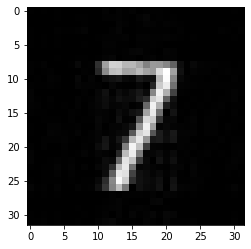

In [28]:
# Calculate recombined matrix mat
mat = np.matrix(u_learned[:, :rank]) * np.diag(d_learned[:rank]) * np.matrix(
    v_dagger_learned[:rank, :])

# Show recombination result
reconstimg = np.abs(mat)
pyplot.imshow(reconstimg, cmap='gray')

可以看到，图像压缩只取前8个奇异值作近似得到的结果仍具有较好的辨识度。

## 项目总结

本次复现我完成了量子版本的奇异值分解变分算法，成功应用算法分解随机8*8的复数矩阵、压缩矩阵分析误差并与经典奇异值分解算法结果相对比。

虽然论文里理论上是使用变分量子神经网络来近似优化，但在实际代码中，原作者使用的是将量子网络转换成经典张量网络优化，又转换回了经典计算机上，并未利用到量子计算机的特性。

考虑到**MindQuantum**是模拟真实物理上的量子计算机，基于测量给出结果，我学习了**MindQuantum**的用法后发现`get_expectation_with_grad` 方法可以用来计算如下表达式的值和线路中参数的梯度。

$$
E(\theta) = \langle\phi|U_l^{\dagger}(\theta) H U_r(\theta)|\psi\rangle
$$

我将待分解矩阵M嵌入哈密顿量H中，将 $U_l(\theta)$ 设置成 $U(\theta)$ ， $U_r(\theta)$ 设置成 $V(\psi)$ ，通过模拟器的`set_qs`设置模拟器的状态为我所取的测量基，从而获取到给定测量基下的测量结果，即对应位置的奇异值。再利用**MindQuantum**的 `MQAnsatzOnlyLayer` 搭建出基于各测量基下的量子网络层，并结合**MindSpore**提供的经典学习框架构建出量子经典混合网络，实现对量子网络层加权求和，从而构建出损失函数并进行优化。

这种方法更符合量子计算的逻辑，更能发挥出量子ansatz的优势，从最终结果来看，这种方法的误差也要优于原作者转换成张量网络求解的方法。

下面两图是量子奇异值分解(VQSVD)误差与经典奇异值分解误差(SVD)对比，其中第一图是使用新算法复现出的结果，第二题图是使用原算法画出的图，二者对比可以发现新算法的误差优于原算法。

![error](https://gitee.com/mindspore/mindquantum/raw/research/paper_recurrence/38_lolo1222/figure/error.png)
![error_baidu](https://gitee.com/mindspore/mindquantum/raw/research/paper_recurrence/38_lolo1222/figure/error_bd.png)

下面两图是在案例二：图像压缩中运行出的结果，其中左图是使用新算法复现出的结果，右图是使用原算法画出的图，二者对比可以发现使用新算法压缩出的图片效果要优于原算法。

![compress](https://gitee.com/mindspore/mindquantum/raw/research/paper_recurrence/38_lolo1222/figure/compress.png)
![compress_baidu](https://gitee.com/mindspore/mindquantum/raw/research/paper_recurrence/38_lolo1222/figure/compress_bd.png)

本论文展示出了变分量子线路的强大，它只需几个比特就可以完成指数级矩阵的运算，未来我们可以考虑基于变分量子线路，通过搭建量子经典混合神经网络求解量子奇异值转换的多项式参数，从而解决算法的精度问题。

---
## 参考文献

[1] Wang, X., Song, Z., & Wang, Y. Variational Quantum Singular Value Decomposition. [Quantum, 5, 483 (2021).](https://quantum-journal.org/papers/q-2021-06-29-483/)